<center><h3>ภาคผนวก</h3></center>

In [14]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
def load_txt(path):
    f=open(path, "r")
    if(path[-3:] == 'txt'):
        contents =f.readlines()

        dataset = np.zeros((len(contents)-2,len(contents[2].split('\t'))-1))
        label = np.zeros((len(contents)-2))

        for i in range(len(contents)-2):
            x = contents[i+2].split("\t")
            for j in range(len(x)):
                if j != len(x) - 1 :
                    dataset[i][j] = float(x[j])
                else :
                    label[i] = float(x[j][:-1])
    else :
        contents =f.readlines()
        n_data = int(len(contents)/3)
        dataset = np.zeros((n_data,2))
        label = np.zeros((n_data,2))
        j = 0
        count = 0
        for i in range(len(contents)):
            if(j == 1):
                dataset[count][0] = float(contents[i].split()[0])
                dataset[count][1] = float(contents[i].split()[1])
            if(j == 2):
                label[count][0] = int(contents[i].split()[0])
                label[count][1] = int(contents[i].split()[1])
                count = count + 1
                j = -1
            j += 1
            
    return dataset,label

def norm(data_r):
    data = data_r.copy()
    datanorm = (data - data.min())/(data.max() - data.min()) 
    return datanorm, data.max(), data.min()

def convert_norm(pred,mx,mn):
    return pred*(mx - mn) + mn

In [16]:
import numpy as np
class NN :
    
    def __init__(self,shape,nueral_shape,acti_funct):
        shape[1:1] = nueral_shape 
        self.shape = shape
        self.act_func = acti_funct
        self.weights = self.init_weights(self.shape)
        self.outputs = None
        self.deltas = None
        self.del_old_weights = None
        
    def init_old_weights(self,network_shape):
        weight_arrays = []
        for i in range(0, len(network_shape) - 1):
            cur_idx = i
            next_idx = i + 1
            weight_array = np.zeros((network_shape[next_idx], network_shape[cur_idx]))
            weight_arrays.append(weight_array)
        
        return weight_arrays
    
    def init_weights(self,network_shape):
        weight_arrays = []
        for i in range(0, len(network_shape) - 1):
            cur_idx = i
            next_idx = i + 1
            weight_array = 2*np.random.rand(network_shape[next_idx], network_shape[cur_idx]) - 1
            weight_arrays.append(weight_array)

        return weight_arrays


    def predict(self,sample):
        
        current_input =  (sample.copy()).T
        outputs = []
        for network_weight in self.weights:
            current_output_temp = np.dot(network_weight, current_input)
            current_output = self.acti_funct(current_output_temp)
            outputs.append(current_output)
            current_input = current_output
        
        if(self.shape[-1] == 1) :
            return current_output.T
        else :
            tp = None 
            fp = None 
            for i in range(len(outputs[-1])):
                if( i == 0) :
                    tp = outputs[-1][i]
                else :
                    fp = outputs[-1][i]
                    tp = np.vstack((tp, fp)).T
            return np.argmax(tp, axis=1)
                    
    def train(self,sample, d_out, training_rate,momentum_rate,epoch,show=True):
        sample_T = (sample.copy()).T
        d_out_T = (d_out.copy()).T
        for i in range(epoch):
            self.FW_NN(sample_T)
            self.BW_NN(d_out_T)
            self.update_weights(sample_T,learning_rate,momentum_rate,i)
            sqe = self.sum_sqaure_error(self.predict(sample),d_out_T)
            if(show and i % 10 == 0):
                print('Epoch : #'+str(i)+',  Sum Square Error : '+str(sqe))
            if sqe < np.finfo(np.float32).eps :
                break
                
    def FW_NN(self,input):

        current_input = input
        outputs = []
        for w in self.weights:
            current_output_tmp = np.dot(w, current_input)
            current_output = self.acti_funct(current_output_tmp)
            outputs.append(current_output)
            current_input = current_output
        self.outputs = outputs
        
    def BW_NN(self,d_out):
        
        deltas = []
        O_error = d_out - self.outputs[len(self.outputs)-1]
        O_delta = O_error *self.derivertive_acti_funct(self.outputs[len(self.outputs)-1])
        deltas.append(O_delta)

        cur_delta = O_delta
        back_idx = len(self.outputs) - 2

        for w in self.weights[::-1][:-1]:
            hidd_error = np.dot(w.T, cur_delta)
            hidd_delta = hidd_error * self.derivertive_acti_funct(self.outputs[back_idx])
            deltas.append(hidd_delta)
            cur_delta = hidd_delta
            back_idx -= 1
            
        self.deltas = deltas
    
    def update_weights(self,sample,learning_rate,momentum_rate,count):
        index_current_weight = len(self.weights) - 1
        current_dels = []
        for d in self.deltas:
            sample_used = None
            if index_current_weight - 1 < 0:
                sample_used = sample
            else:
                sample_used = self.outputs[index_current_weight - 1]
                
            current_delta = learning_rate*np.dot(d, sample_used.T)
            
            if(count == 0) :
                self.weights[index_current_weight] +=  current_delta
            else :
                self.weights[index_current_weight] +=  momentum_rate*self.del_old_weights[index_current_weight]+ current_delta
            index_current_weight -= 1
            current_dels.insert(0, current_delta)
            
        self.del_old_weights = current_dels

    def acti_funct(self,v):
        if self.act_func == 'sigmoid' :
            return 1 / (1 + np.exp(-v))
        if self.act_func == 'tanh' :
            return np.tanh(v)
        if self.act_func == 'linear' :
            return v
        return v

    def derivertive_acti_funct(self,v):
        if self.act_func == 'sigmoid' :
            return v * (1 - v)
        if self.act_func == 'tanh' :
            return 1 - (v ** 2)
        if self.act_func == 'linear' :
            return 1
        return v

        
    def sum_sqaure_error(self,pred,real):
        real_m = real.copy()
        sums = 0
        if(real.ndim > 1) :
            tp = None 
            fp = None 
            for i in range(len(real_m)):
                if( i == 0) :
                    tp = real_m[i]
                else :
                    fp = real_m[i]
                    tp = np.vstack((tp, fp)).T
            real_m = np.argmax(tp, axis=1)
        for i in range(len(pred)):
            sums = sums + np.square(pred[i]-real_m[i])
        return sums/2
    
    def conf_matrix(self,pred,true,is_norm=False,confuse=True,Table=True):
        true_m = np.zeros(len(true))
        if(true.ndim > 1) :
            for i in range(len(true)):
                true_m[i] = np.argmax(true[i], axis=0)
        if(is_norm):
            sqr_error = 0 
            if(Table):
                print('Desired Output\t\t|\tPredict\t\t\t|\tError')
                print('-----------------------------------------------------------------------------')
            for i in range(len(true)):
                error = round(true[i] - round(pred[i][0],8),2)
                if(Table):
                    print(str(int(true[i]))+'\t\t\t\t|\t'+str(format(round(pred[i][0],8), '.8f'))+'\t\t|\t'+str(error))
                sqr_error = sqr_error + (error * error)
            if(Table):
                print('-----------------------------------------------------------------------------')
                print('\t\t Mean Square Error = '+str(round(sqr_error/len(true),6)))
                print('=======================================')
            return round(sqr_error/len(true),6)
        else :
            if(Table):
                print('Desired Output\t\t|\tPredict\t\t\t')
                print('------------------------------------------------')
                for i in range(len(true)):
                    print(str(int(true_m[i]))+'\t\t\t\t|\t'+str(pred[i]))
                print('------------------------------------------------')
        if(confuse):
            print('\n\t\t Confusion Matrix')
            TP = 0
            FN = 0
            FP = 0
            TN = 0
            for i in range(len(true)):
                if((pred[i] == 0) and ( true_m[i] == 0)):
                    TN = TN + 1 
                elif((pred[i] == 1) and ( true_m[i] == 1)):
                    TP = TP + 1
                elif((pred[i] == 1) and ( true_m[i] == 0)):
                    FP = FP + 1
                else :
                    FN = FN + 1

            print(' ----------------------------------------')
            for i in range(8):
                print('|\t\t\t|\t\t\t|')
                if(i == 1):
                    print('|\t    '+str(TN)+'\t\t|\t    '+str(FP)+'\t\t|\t '+str(FP+TN))
                if(i == 3):
                    print(' ----------------------------------------')
                if(i == 5):
                    print('|\t    '+str(FN)+'\t\t|\t    '+str(TP)+'\t\t|\t '+str(FN+TP))
            print(' ----------------------------------------')
            print(' \t    '+str(TN+FN)+'\t\t       '+str(FP+TP)+'\t\t\t'+str(TN+FP+FN+TP))
            print('')
            print('Accuracy : '+str((TN+TP)/(TN+FP+FN+TP)))
            return((TN+TP)/(TN+FP+FN+TP))

In [17]:
def load_data(name,cross):
    is_norm = False
    if(name  == 1):
        dataset,label = load_txt("./Flood_dataset.txt")
        dataset,mx_dataset,mn_dataset = norm(dataset)
        label,mx_label,mn_label = norm(label)
        is_norm = True
        max_min = [mx_dataset,mn_dataset,mx_label,mn_label]
    else :
        dataset,label = load_txt("./cross.pat")
    n_sample = np.arange(len(dataset))
    np.random.shuffle(n_sample)
    if(is_norm) :
        return dataset,label,n_sample,max_min
    else :
        return dataset,label,n_sample

In [18]:
def MLP(Nueral,learning_rate,momentum_rate,activation,epoch,cross_valda_train_test,data_num) :
    if(data_num == 0):
        print('------------------- Variable -------------------\n')
        dataset,label,n_sample = load_data(data_num,cross_valda_train_test)
        data_name = 'cross.pat'
    else :
        print('-------------------------------- Variable --------------------------------\n')
        dataset,label,n_sample,max_min = load_data(data_num,cross_valda_train_test)
        data_name = 'Flood data set'
    n_test_per_round = int(len(dataset)*cross_valda_train_test[1]/100)
    print('Datafile : ' +str(data_name),end='\n')
    print('Nueral name : '+str(len(dataset[0]))+'-',end='')
    for i in range(len(Nueral)):
        print(str(Nueral[i])+'-',end='')
    print(label.ndim,end='\n')
    print('Learning rate : '+str(learning_rate),end='\n')
    print('Momentum rate : '+str(momentum_rate),end='\n')
    print('Activaion Function : ' +str(activation),end='\n')
    print('Cross validation : ['+str(cross_valda_train_test[0])+' : '+str(cross_valda_train_test[1])+']',end='\n')
    print('#Epoch : '+str(epoch),end='\n')
    error_avg = []
    acc_avg = []
    for i in range(10):
        test_data = n_sample[i*n_test_per_round:i*n_test_per_round+n_test_per_round]
        train_data = list(set(n_sample) - set(test_data))
        nn = NN([len(dataset[0]),label.ndim],Nueral,activation)
        nn.train(dataset[train_data],label[train_data],learning_rate,momentum_rate,epoch,False)
        pred = nn.predict(dataset[test_data])
        if(data_num == 1):
#             print('\n-------------------------------- Round : '+str(i)+' --------------------------------')
            pred = convert_norm(pred,max_min[2],max_min[3])
            test_label = convert_norm(label[test_data],max_min[2],max_min[3])
            error_avg.append(nn.conf_matrix(pred,test_label,is_norm=True,confuse=False,Table=True))
        else :
#             print('\n----------------- Round : '+str(i)+' -----------------')
            acc_avg.append(nn.conf_matrix(pred,label[test_data],is_norm=False,confuse=True,Table=True))
    if(data_num == 1):
        print('\n********  Mean Square Error Average : ' + str(round(np.sum(error_avg)/len(error_avg),4))+'  *********')
        print(np.min(error_avg))
        return round(np.sum(error_avg)/len(error_avg),4),np.min(error_avg)
    else :
        print('\n********  Accuracy Average : ' + str(round(np.sum(acc_avg)/len(acc_avg),4))+'  *********')
        return round(np.sum(acc_avg)/len(acc_avg),4),np.max(acc_avg)

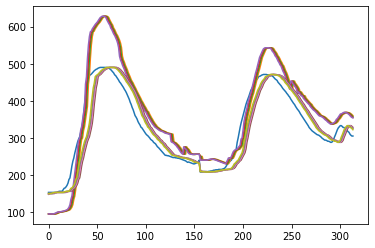

In [39]:
# Visualization Flood_dataset.txt
dataset, label = load_txt("./Flood_dataset.txt")
plt.plot(label, label="Y")
plt.plot(dataset)
plt.show()

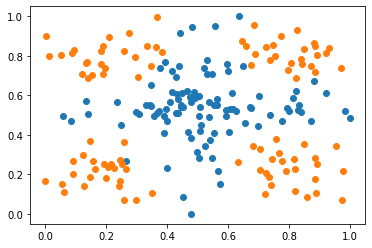

In [40]:
# Visualization cross.pat
dataset, label = load_txt("./cross.pat")

setAx = []
setAy = []
setBx = []
setBy = []

for i in range(len(label)):
    if label[i][0] == 0:
        setAx.append(dataset[i][0])
        setAy.append(dataset[i][1])
    if label[i][0] == 1:
        setBx.append(dataset[i][0])
        setBy.append(dataset[i][1])

plt.scatter(setAx, setAy, label='SetA')
plt.scatter(setBx, setBy, label='SetB')

-------------------------------- Variable --------------------------------

Datafile : Flood data set
Nueral name : 8-10-6-1
Learning rate : 0.01
Momentum rate : 0.07
Activaion Function : sigmoid
Cross validation : [90 : 10]
#Epoch : 1000
Desired Output		|	Predict			|	Error
-----------------------------------------------------------------------------
250				|	235.85843059		|	14.14
470				|	452.92731285		|	17.07
268				|	283.92428303		|	-15.92
209				|	225.97407321		|	-16.97
490				|	469.43542637		|	20.56
309				|	332.17434414		|	-23.17
246				|	197.35777999		|	48.64
440				|	435.71421464		|	4.29
344				|	370.07459442		|	-26.07
156				|	185.14115252		|	-29.14
431				|	429.02032006		|	1.98
478				|	463.78929327		|	14.21
230				|	234.32893917		|	-4.33
317				|	341.98875523		|	-24.99
385				|	396.63228855		|	-11.63
331				|	333.58916964		|	-2.59
465				|	449.59825365		|	15.4
368				|	388.32923467		|	-20.33
239				|	241.89204640		|	-2.89
270				|	210.65615352		|	59.34
420				|	372.98454118	

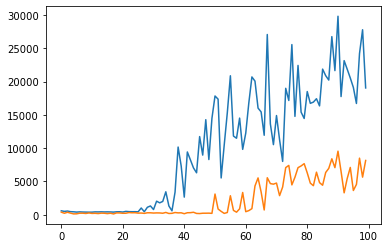

In [41]:
# Find best learning_rate for Flood_dataset.txt
error_arr = np.zeros(100)
minn_arr = np.zeros(100)
for i in range(1,101):
    Nueral = [10,6] 
    cross_valda_train_test = [90,10] # train 90 , test 10
    data_num = 1 # 0 = cross.pat , 1 = flood data set
    learning_rate = i*0.01
    momentum_rate = 0.07
    activation = 'sigmoid'
    epoch = 1000
    error,minn = MLP(Nueral,learning_rate,momentum_rate,activation,epoch,cross_valda_train_test,data_num)
    error_arr[i-1] = error
    minn_arr[i-1] = minn

plt.plot(error_arr, label="Error Avg")
plt.plot(minn_arr, label="Min Error")
plt.show()

------------------- Variable -------------------

Datafile : cross.pat
Nueral name : 2-10-6-2
Learning rate : 0.01
Momentum rate : 0.07
Activaion Function : sigmoid
Cross validation : [90 : 10]
#Epoch : 1000
Desired Output		|	Predict			
------------------------------------------------
1				|	1
1				|	1
1				|	1
1				|	0
1				|	0
0				|	0
0				|	0
1				|	0
0				|	0
1				|	1
1				|	1
0				|	1
1				|	1
0				|	1
0				|	0
0				|	1
0				|	1
0				|	0
0				|	1
1				|	0
------------------------------------------------

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    5		|	    5		|	 10
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    4		|	    6		|	 10
|			|			|
|			|			|
 ----------------------------------------
 	    9		       11			20

Accuracy : 0.55
Desired Output		|	Predict			
------------------------------------------------
0				|	1
0				|	1
1				|	0
1				|	1
0				|	1
0				|	1
1				|	1
1				|	1
0				|	1
0				|	1
1

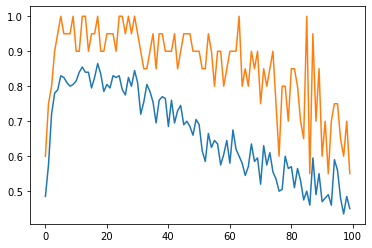

In [42]:
# Find best learning_rate for cross.pat
error_arr = np.zeros(100)
minn_arr = np.zeros(100)
for i in range(1,101):
    Nueral = [10,6] 
    cross_valda_train_test = [90,10] # train 90 , test 10
    data_num = 0 # 0 = cross.pat , 1 = flood data set
    learning_rate = i*0.01
    momentum_rate = 0.07
    activation = 'sigmoid'
    epoch = 1000
    error,minn = MLP(Nueral,learning_rate,momentum_rate,activation,epoch,cross_valda_train_test,data_num)
    error_arr[i-1] = error
    minn_arr[i-1] = minn

plt.plot(error_arr, label="Error Avg")
plt.plot(minn_arr, label="Min Error")
plt.show()

-------------------------------- Variable --------------------------------

Datafile : Flood data set
Nueral name : 8-10-6-1
Learning rate : 0.12
Momentum rate : 0.01
Activaion Function : sigmoid
Cross validation : [90 : 10]
#Epoch : 1000
Desired Output		|	Predict			|	Error
-----------------------------------------------------------------------------
356				|	340.37374998		|	15.63
236				|	234.19520592		|	1.8
333				|	321.61188367		|	11.39
305				|	300.64570221		|	4.35
325				|	320.79241062		|	4.21
247				|	245.56190955		|	1.44
486				|	478.46238782		|	7.54
455				|	443.07788961		|	11.92
291				|	288.90945133		|	2.09
172				|	168.02466730		|	3.98
490				|	479.29890174		|	10.7
333				|	325.43452384		|	7.57
413				|	364.02779613		|	48.97
401				|	386.99971130		|	14.0
232				|	226.07089520		|	5.93
259				|	265.83093843		|	-6.83
350				|	266.83097565		|	83.17
444				|	430.22892128		|	13.77
420				|	376.81144146		|	43.19
156				|	167.16058099		|	-11.16
245				|	233.39482420		|	11.61
427				

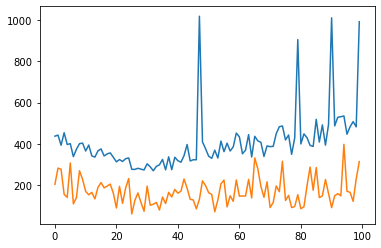

In [43]:
# Find best momentum_rate for Flood_dataset.txt
error_arr = np.zeros(100)
minn_arr = np.zeros(100)
for i in range(1,101):
    Nueral = [10,6] 
    cross_valda_train_test = [90,10] # train 90 , test 10
    data_num = 1 # 0 = cross.pat , 1 = flood data set
    learning_rate = 0.12
    momentum_rate = i*0.01
    activation = 'sigmoid'
    epoch = 1000
    error,minn = MLP(Nueral,learning_rate,momentum_rate,activation,epoch,cross_valda_train_test,data_num)
    error_arr[i-1] = error
    minn_arr[i-1] = minn

plt.plot(error_arr, label="Error Avg")
plt.plot(minn_arr, label="Min Error")
plt.show()

------------------- Variable -------------------

Datafile : cross.pat
Nueral name : 2-10-6-2
Learning rate : 0.12
Momentum rate : 0.01
Activaion Function : sigmoid
Cross validation : [90 : 10]
#Epoch : 1000
Desired Output		|	Predict			
------------------------------------------------
0				|	0
1				|	1
1				|	1
0				|	1
0				|	1
0				|	0
1				|	1
0				|	1
0				|	0
0				|	1
0				|	0
0				|	0
0				|	0
1				|	1
0				|	0
1				|	1
0				|	1
0				|	1
0				|	0
1				|	1
------------------------------------------------

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    8		|	    6		|	 14
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    0		|	    6		|	 6
|			|			|
|			|			|
 ----------------------------------------
 	    8		       12			20

Accuracy : 0.7
Desired Output		|	Predict			
------------------------------------------------
0				|	0
1				|	1
0				|	0
0				|	0
1				|	1
1				|	1
0				|	0
0				|	0
1				|	0
1				|	1
0		

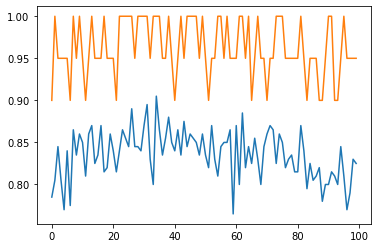

In [19]:
# Find best momentum_rate for cross.pat
error_arr = np.zeros(100)
minn_arr = np.zeros(100)
for i in range(1,101):
    Nueral = [10,6] 
    cross_valda_train_test = [90,10] # train 90 , test 10
    data_num = 0 # 0 = cross.pat , 1 = flood data set
    learning_rate = 0.12
    momentum_rate = i*0.01
    activation = 'sigmoid'
    epoch = 1000
    error,minn = MLP(Nueral,learning_rate,momentum_rate,activation,epoch,cross_valda_train_test,data_num)
    error_arr[i-1] = error
    minn_arr[i-1] = minn

plt.plot(error_arr, label="Error Avg")
plt.plot(minn_arr, label="Min Error")
plt.show()

-------------------------------- Variable --------------------------------

Datafile : Flood data set
Nueral name : 8-10-6-1
Learning rate : 0.12
Momentum rate : 0.22
Activaion Function : sigmoid
Cross validation : [90 : 10]
#Epoch : 10
Desired Output		|	Predict			|	Error
-----------------------------------------------------------------------------
410				|	347.16638253		|	62.83
333				|	328.88219414		|	4.12
331				|	330.10615861		|	0.89
237				|	285.78780352		|	-48.79
154				|	276.40932570		|	-122.41
305				|	330.75430542		|	-25.75
290				|	326.63976635		|	-36.64
156				|	276.84880948		|	-120.85
155				|	276.50886503		|	-121.51
325				|	336.31644643		|	-11.32
265				|	323.77669648		|	-58.78
300				|	312.85005104		|	-12.85
210				|	305.50141924		|	-95.5
345				|	338.98453604		|	6.02
328				|	314.41664412		|	13.58
311				|	334.01247911		|	-23.01
280				|	326.02388471		|	-46.02
468				|	347.95858467		|	120.04
292				|	328.44775548		|	-36.45
230				|	310.48554646		|	-80.49
214				|	305.48

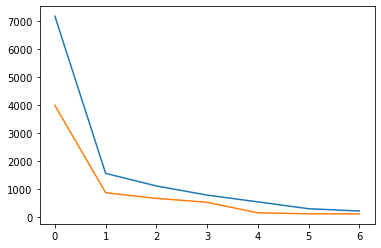

In [22]:
#Find best epoch for Flood_dataset.txt
error_arr = [10, 50, 100, 250, 500, 1000, 2000]
minn_arr = [10, 50, 100, 250, 500, 1000, 2000]
for i in error_arr:
    temp = error_arr.copy()
    Nueral = [10,6] 
    cross_valda_train_test = [90,10] # train 90 , test 10
    data_num = 1 # 0 = cross.pat , 1 = flood data set
    learning_rate = 0.12
    momentum_rate = 0.22
    activation = 'sigmoid'
    epoch = i
    error,minn = MLP(Nueral,learning_rate,momentum_rate,activation,epoch,cross_valda_train_test,data_num)
    error_arr[temp.index(i)] = error
    minn_arr[temp.index(i)] = minn

plt.plot(error_arr, label="Error Avg")
plt.plot(minn_arr, label="Min Error")
plt.show()

------------------- Variable -------------------

Datafile : cross.pat
Nueral name : 2-10-6-2
Learning rate : 0.16
Momentum rate : 0.57
Activaion Function : sigmoid
Cross validation : [90 : 10]
#Epoch : 10
Desired Output		|	Predict			
------------------------------------------------
1				|	0
1				|	0
0				|	0
0				|	0
1				|	0
1				|	0
0				|	0
1				|	0
0				|	0
1				|	0
1				|	0
0				|	0
0				|	0
0				|	0
1				|	0
0				|	0
1				|	0
1				|	0
0				|	0
1				|	0
------------------------------------------------

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    9		|	    0		|	 9
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    11		|	    0		|	 11
|			|			|
|			|			|
 ----------------------------------------
 	    20		       0			20

Accuracy : 0.45
Desired Output		|	Predict			
------------------------------------------------
0				|	1
0				|	1
1				|	1
0				|	1
1				|	1
0				|	1
0				|	1
0				|	1
0				|	1
1				|	1
1		

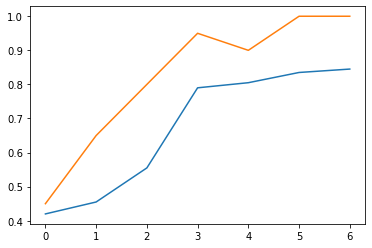

In [24]:
#Find best epoch for cross.pat
error_arr = [10, 50, 100, 250, 500, 1000, 2000]
minn_arr = [10, 50, 100, 250, 500, 1000, 2000]
for i in error_arr:
    temp = error_arr.copy()
    Nueral = [10,6] 
    cross_valda_train_test = [90,10] # train 90 , test 10
    data_num = 0 # 0 = cross.pat , 1 = flood data set
    learning_rate = 0.16
    momentum_rate = 0.57
    activation = 'sigmoid'
    epoch = i
    error,minn = MLP(Nueral,learning_rate,momentum_rate,activation,epoch,cross_valda_train_test,data_num)
    error_arr[temp.index(i)] = error
    minn_arr[temp.index(i)] = minn

plt.plot(error_arr, label="Error Avg")
plt.plot(minn_arr, label="Min Error")
plt.show()

-------------------------------- Variable --------------------------------

Datafile : Flood data set
Nueral name : 8-1-1
Learning rate : 0.12
Momentum rate : 0.22
Activaion Function : sigmoid
Cross validation : [90 : 10]
#Epoch : 1000
Desired Output		|	Predict			|	Error
-----------------------------------------------------------------------------
284				|	298.24599684		|	-14.25
412				|	314.12510475		|	97.87
296				|	303.76401801		|	-7.76
230				|	255.22185359		|	-25.22
405				|	318.15240483		|	86.85
340				|	280.36863649		|	59.63
268				|	294.04080605		|	-26.04
333				|	312.86178364		|	20.14
454				|	318.95892710		|	135.04
381				|	317.17697244		|	63.82
405				|	312.53638108		|	92.46
357				|	315.41297462		|	41.59
484				|	321.04275966		|	162.96
234				|	255.22758328		|	-21.23
288				|	300.14830865		|	-12.15
485				|	321.07490386		|	163.93
374				|	316.39919035		|	57.6
237				|	173.79055147		|	63.21
288				|	299.50792405		|	-11.51
362				|	305.08418161		|	56.92
172				|	157.59721777	

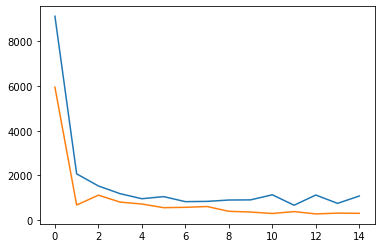

In [26]:
#Find best hidden_layer 1layer for Flood_dataset.txt
error_arr = np.zeros(15)
minn_arr = np.zeros(15)
for i in range(1,16):
    Nueral = [i] 
    cross_valda_train_test = [90,10] # train 90 , test 10
    data_num = 1 # 0 = cross.pat , 1 = flood data set
    learning_rate = 0.12
    momentum_rate = 0.22
    activation = 'sigmoid'
    epoch = 1000
    error,minn = MLP(Nueral,learning_rate,momentum_rate,activation,epoch,cross_valda_train_test,data_num)
    error_arr[i-1] = error
    minn_arr[i-1] = minn
plt.plot(error_arr)
plt.plot(minn_arr)

In [ ]:
#Find best hidden_layer 2layer for Flood_dataset.txt
error_arr_2 = np.zeros(225)
minn_arr_2 = np.zeros(225)
for i in range(1,16):
    for j in range(1,16):
        Nueral = [i,j] 
        cross_valda_train_test = [90,10] # train 90 , test 10
        data_num = 1 # 0 = cross.pat , 1 = flood data set
        learning_rate = 0.12
        momentum_rate = 0.22
        activation = 'sigmoid'
        epoch = 1000
        error,minn = MLP(Nueral,learning_rate,momentum_rate,activation,epoch,cross_valda_train_test,data_num)
        error_arr_2[((i-1)*15)+j] = error
        minn_arr_2[((i-1)*15)+j] = minn
plt.plot(error_arr_2)
plt.plot(minn_arr_2)

In [ ]:
#Find best hidden_layer 1layer for cross.pat
error_arr = np.zeros(15)
minn_arr = np.zeros(15)
for i in range(1,16):
    Nueral = [i] 
    cross_valda_train_test = [90,10] # train 90 , test 10
    data_num = 0 # 0 = cross.pat , 1 = flood data set
    learning_rate = 0.16
    momentum_rate = 0.57
    activation = 'sigmoid'
    epoch = 1000
    error,minn = MLP(Nueral,learning_rate,momentum_rate,activation,epoch,cross_valda_train_test,data_num)
    error_arr[i-1] = error
    minn_arr[i-1] = minn
plt.plot(error_arr)
plt.plot(minn_arr)

In [ ]:
#Find best hidden_layer 2layer for cross.pat
error_arr_2 = np.zeros((15,15))
minn_arr_2 = np.zeros((15,15))
for i in range(1,15):
    for j in range(1,15):
        Nueral = [i,j] 
        cross_valda_train_test = [90,10] # train 90 , test 10
        data_num = 0 # 0 = cross.pat , 1 = flood data set
        learning_rate = 0.16
        momentum_rate = 0.57
        activation = 'sigmoid'
        epoch = 1000
        error,minn = MLP(Nueral,learning_rate,momentum_rate,activation,epoch,cross_valda_train_test,data_num)
        error_arr_2[((i-1)*15)+j] = error
        minn_arr_2[((i-1)*15)+j] = minn
plt.plot(error_arr)
plt.plot(minn_arr)